In [1]:
!pip install patchify

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm import tqdm
import numpy as np
from patchify import patchify
import time

# Load data from folders


In [2]:
def load_data(path):
    train_x = sorted(glob(os.path.join(path, "train", "*.tiff")))
    train_y = sorted(glob(os.path.join(path, "train_mask", "*.tif")))

    validate_x = sorted(glob(os.path.join(path, "validate", "*.tiff")))
    validate_y = sorted(glob(os.path.join(path, "validate_mask", "*.tif")))

    return (train_x, train_y), (validate_x, validate_y)


data_path = "/content/drive/MyDrive/Datasets/MIT Buildings Dataset - Shorter version"
(train_x, train_y), (valid_x, valid_y) = load_data(data_path)   ##len of train_x is 20

In [3]:
print (len(train_x), len(train_y), len(valid_x), len(valid_y))

20 20 10 10


# Create subclass Dataset to prepare the data

In [20]:
class ViTPatchDataset(Dataset):
    def __init__(self, image_paths, label_paths, patch_size, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.patch_size = patch_size
        self.transform = transform if transform else transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = self.load_image(self.image_paths[idx], is_label=False)
        label = self.load_image(self.label_paths[idx], is_label=True)
        image_patches = self.create_patches(image)    ## we only patch the images , but labels are NOT patched
        return image_patches, label

    def load_image(self, path, is_label=False):
        image = Image.open(path).convert("L" if is_label else "RGB")
        if self.transform:
            image = self.transform(image)
        return image

    def create_patches(self, image):
        '''create image patches'''
        image_np = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
        patches = patchify(image_np, (self.patch_size, self.patch_size, image_np.shape[2]), step=self.patch_size)
        patches = patches.reshape(-1, self.patch_size, self.patch_size, image_np.shape[2])  # Flatten patches
        patches = torch.tensor(patches).permute(0, 3, 1, 2)  # Convert to (num_patches, C, patch_size, patch_size)
        patches = patches.reshape(256, 768)

        return patches


# Test data usage

In [23]:
## Example usage:
patch_size = 16
dataset = ViTPatchDataset(train_x, train_y, patch_size)

In [27]:
# # Iterate through the dataset
for patches, y in dataset:
    print(patches.shape)  # Each item will be of shape (num_patches, C, patch_size, patch_size)
    print(y.shape)
    break

torch.Size([256, 768])
torch.Size([1, 256, 256])


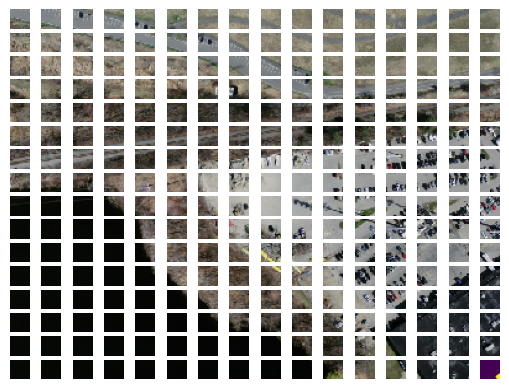

In [35]:
for i in range(16):
  for j in range(16):
    plt.subplot(16,16,i*16+j+1)
    plt.imshow(patches[i*16+j].reshape(3, 16, 16).permute(1, 2, 0).numpy())
    plt.axis('off')


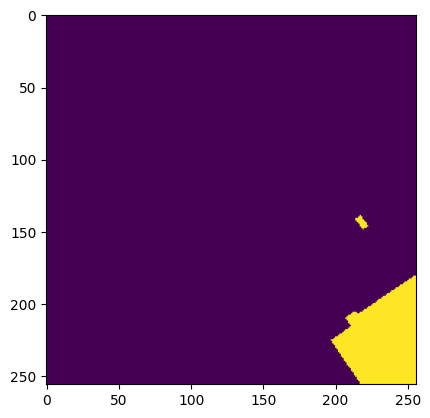

In [34]:
plt.imshow(y.permute(1, 2, 0).numpy())

# Create UNETR Model

In [38]:
config = {}
config["image_size"] = 256
config["num_layers"] = 12
config["hidden_dim"] = 768
config["mlp_dim"] = 3072
config["num_heads"] = 12
config["dropout_rate"] = 0.1
config["num_patches"] = 256
config["patch_size"] = 16
config["num_channels"] = 3



class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )


    def forward(self, x):
        return self.layers(x)


class DeconvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.deconv = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        return self.deconv(x)


class UNETR_2D(nn.Module):
    def __init__(self, cf):
        super().__init__()
        self.cf = cf

        """ Patch + Position Embeddings """
        self.patch_embed = nn.Linear(
            cf["patch_size"]*cf["patch_size"]*cf["num_channels"],
            cf["hidden_dim"]
        )

        self.positions = torch.arange(start=0, end=cf["num_patches"], step=1, dtype=torch.int32)
        self.pos_embed = nn.Embedding(cf["num_patches"], cf["hidden_dim"])

        """ Transformer Encoder """
        self.trans_encoder_layers = []

        for i in range(cf["num_layers"]):
            layer = nn.TransformerEncoderLayer(
                d_model=cf["hidden_dim"],
                nhead=cf["num_heads"],
                dim_feedforward=cf["mlp_dim"],
                dropout=cf["dropout_rate"],
                activation=nn.GELU(),
                batch_first=True
            )
            self.trans_encoder_layers.append(layer)

        """ CNN Decoder """
        ## Decoder 1
        self.d1 = DeconvBlock(cf["hidden_dim"], 512)
        self.s1 = nn.Sequential(
            DeconvBlock(cf["hidden_dim"], 512),
            ConvBlock(512, 512)
        )
        self.c1 = nn.Sequential(
            ConvBlock(512+512, 512),
            ConvBlock(512, 512)
        )

        ## Decoder 2
        self.d2 = DeconvBlock(512, 256)
        self.s2 = nn.Sequential(
            DeconvBlock(cf["hidden_dim"], 256),
            ConvBlock(256, 256),
            DeconvBlock(256, 256),
            ConvBlock(256, 256)
        )
        self.c2 = nn.Sequential(
            ConvBlock(256+256, 256),
            ConvBlock(256, 256)
        )

        ## Decoder 3
        self.d3 = DeconvBlock(256, 128)
        self.s3 = nn.Sequential(
            DeconvBlock(cf["hidden_dim"], 128),
            ConvBlock(128, 128),
            DeconvBlock(128, 128),
            ConvBlock(128, 128),
            DeconvBlock(128, 128),
            ConvBlock(128, 128)
        )
        self.c3 = nn.Sequential(
            ConvBlock(128+128, 128),
            ConvBlock(128, 128)
        )

        ## Decoder 4
        self.d4 = DeconvBlock(128, 64)
        self.s4 = nn.Sequential(
            ConvBlock(3, 64),
            ConvBlock(64, 64)
        )
        self.c4 = nn.Sequential(
            ConvBlock(64+64, 64),
            ConvBlock(64, 64)
        )

        """ Output """
        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Patch + Position Embeddings """
        patch_embed = self.patch_embed(inputs)   ## [8, 256, 768]

        positions = self.positions
        pos_embed = self.pos_embed(positions)   ## [256, 768]

        x = patch_embed + pos_embed ## [8, 256, 768]

        """ Transformer Encoder """
        skip_connection_index = [3, 6, 9, 12]
        skip_connections = []

        for i in range(self.cf["num_layers"]):
            layer = self.trans_encoder_layers[i]
            x = layer(x)

            if (i+1) in skip_connection_index:
                skip_connections.append(x)

        """ CNN Decoder """
        z3, z6, z9, z12 = skip_connections

        ## Reshaping
        batch = inputs.shape[0]
        z0 = inputs.view((batch, self.cf["num_channels"], self.cf["image_size"], self.cf["image_size"]))

        shape = (batch, self.cf["hidden_dim"], self.cf["patch_size"], self.cf["patch_size"])
        z3 = z3.view(shape)
        z6 = z6.view(shape)
        z9 = z9.view(shape)
        z12 = z12.view(shape)


        ## Decoder 1
        x = self.d1(z12)
        s = self.s1(z9)
        x = torch.cat([x, s], dim=1)
        x = self.c1(x)

        ## Decoder 2
        x = self.d2(x)
        s = self.s2(z6)
        x = torch.cat([x, s], dim=1)
        x = self.c2(x)

        ## Decoder 3
        x = self.d3(x)
        s = self.s3(z3)
        x = torch.cat([x, s], dim=1)
        x = self.c3(x)

        ## Decoder 4
        x = self.d4(x)
        s = self.s4(z0)
        x = torch.cat([x, s], dim=1)
        x = self.c4(x)

        """ Output """
        output = self.output(x)

        return output

# Test the model on a random tensor x

In [39]:
x = torch.randn((
        2,
        config["num_patches"],
        config["patch_size"]*config["patch_size"]*config["num_channels"]
))

model = UNETR_2D(config)
output = model(x)
print(output.shape)

torch.Size([2, 1, 256, 256])


# Test the model on x from dataset

In [40]:
x , y1 = dataset[0]
print(x.shape)

torch.Size([256, 768])


In [43]:
print(x.unsqueeze(0).shape)

torch.Size([1, 256, 768])


In [44]:
output = model(x.unsqueeze(0))
print(output.shape)

torch.Size([1, 1, 256, 256])


In [49]:
print(output.squeeze(0).permute(1, 2, 0).shape)

torch.Size([256, 256, 1])


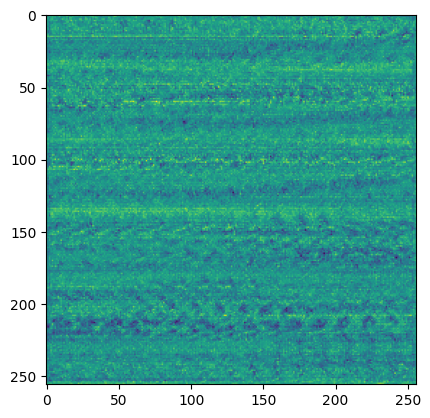

In [50]:
plt.imshow(output.squeeze(0).permute(1, 2, 0).detach().numpy())

# Creat Dataloader (to create batches of data)

In [51]:
""" Dataset and loader """

batch_size = 2
patch_size = 16

train_dataset = ViTPatchDataset(train_x, train_y, patch_size)
validate_dataset = ViTPatchDataset(valid_x, valid_y, patch_size)


train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

validate_loader = DataLoader(
        dataset=validate_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )



# Test Dataloader

In [52]:
for x, y in train_loader:
        print (x.shape)     ## 2, 256, 768      --> we already put batch=2
        print (y.shape)     ## 2, 1, 256, 256   --> we already put batch=2
        break

torch.Size([2, 256, 768])
torch.Size([2, 1, 256, 256])


# Train Functions

In [61]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        # x = x.to(device, dtype=torch.float32)
        # y = y.to(device, dtype=torch.float32)

        x = x.to(dtype=torch.float32)
        y = y.to(dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            # x = x.to(device, dtype=torch.float32)
            # y = y.to(device, dtype=torch.float32)

            x = x.to(dtype=torch.float32)
            y = y.to(dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

# Loss Class:

In [62]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

# Training Optimizer and loss fn


In [63]:
num_epochs = 20
lr = 1e-4

device = torch.device('cuda')
model = UNETR_2D(config)
# model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()


# Training

In [64]:
""" Training the model """
num_epochs = 20
lr = 1e-4
# best_valid_loss = float("inf")

for epoch in range(num_epochs):
        # start_time = time.time()

        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss = evaluate(model, validate_loader, loss_fn, device)

        # """ Saving the model """
        # if valid_loss < best_valid_loss:
        #     data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
        #     print(data_str)

        #     best_valid_loss = valid_loss
        #     torch.save(model.state_dict(), checkpoint_path)

        # end_time = time.time()
        # epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        data_str = f'Epoch: {epoch+1:02} '            ##| Epoch Time: {epoch_mins}m {epoch_secs}s\n'
        data_str += f'\tTrain Loss: {train_loss:.3f}\n'
        data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
        print(data_str)

Epoch: 01 	Train Loss: 1.513
	 Val. Loss: 1.542

Epoch: 02 	Train Loss: 1.491
	 Val. Loss: 1.448

Epoch: 03 	Train Loss: 1.469
	 Val. Loss: 1.391

Epoch: 04 	Train Loss: 1.451
	 Val. Loss: 1.376



KeyboardInterrupt: 